# **Fast, Practical Detection of Potentially Unfair Terms in Consumer Terms of Service**
by Samit Roy




### ENVIRONMENT SETUP AND PACKAGE INSTALLATION ###




In [1]:
!pip -q install -U "pyarrow>=14,<20" datasets transformers accelerate evaluate scikit-learn matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 149.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 162.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 155.4 MB/s eta 0:00:00


### CORE IMPORTS AND DEVICE CONFIGURATION ###

In [2]:
import transformers, datasets, torch, sys
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("Torch:", torch.__version__)
print("Python:", sys.version)

Transformers: 4.57.3
Datasets: 4.0.0
Torch: 2.9.0+cu126
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [3]:
import os, json, time, random, math, re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
from sklearn.metrics import (precision_recall_fscore_support, roc_auc_score,
                             average_precision_score, roc_curve,
                             precision_recall_curve)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

### GLOBAL CONFIG AND LABEL DEFINITIONS ###

In [4]:
# Config
CFG = {
    "dataset_name": "coastalcph/lex_glue",
    "dataset_config": "unfair_tos",
    "use_hf_dataset": True,
    "model_name": "distilbert-base-uncased",
    "batch_size": 16,
    "epochs": 3,
    "lr": 2e-5,
    "weight_decay": 0.01,
    "target_recall_micro": 0.85,            # target micro recall during threshold search
    "output_dir": "outputs_unfair_tos_multilabel"
}
os.makedirs(CFG["output_dir"], exist_ok=True)

UNFAIR_TYPES = [
    "Limitation of liability",
    "Unilateral termination",
    "Unilateral change",
    "Content removal",
    "Contract by using",
    "Choice of law",
    "Jurisdiction",
    "Arbitration",
]
NUM_LABELS = len(UNFAIR_TYPES)
idx2label = {i: n for i, n in enumerate(UNFAIR_TYPES)}
label2idx = {n: i for i, n in enumerate(UNFAIR_TYPES)}

### DATA LOADING, SCHEMA AND TEXT NORMALIZATION ###

In [5]:
# Load dataset and normalize schema

def to_multihot_from_example(ex):
    # Accept either "labels" (list[int]) or "label" (int)
    if "labels" in ex and isinstance(ex["labels"], (list, tuple)):
        ys = np.zeros(NUM_LABELS, dtype=np.float32)
        for j in ex["labels"]:
            if 0 <= int(j) < NUM_LABELS:
                ys[int(j)] = 1.0
        ex["labels"] = ys.tolist()
    elif "label" in ex:  # single class index
        ys = np.zeros(NUM_LABELS, dtype=np.float32)
        j = int(ex["label"])
        if 0 <= j < NUM_LABELS:
            ys[j] = 1.0
        ex["labels"] = ys.tolist()
    else:
        # If missing, treat as no unfair type
        ex["labels"] = [0.0]*NUM_LABELS
    return ex

URL_RE = re.compile(r"https?://\S+|www\.\S+")
SECTION_RE = re.compile(r"(Section|Sec\.?|§)\s*\d+(\.\d+)*", re.IGNORECASE)
POLICY_RE = re.compile(r"(privacy policy|cookie policy|acceptable use policy|terms of use)", re.IGNORECASE)

def normalize_text(s):
    s = s.strip()
    s = URL_RE.sub("<URL>", s)
    s = SECTION_RE.sub("<SECTION>", s)
    s = POLICY_RE.sub("<POLICY>", s)
    return s

def preprocess_batch(batch, text_col="text"):
    texts = [normalize_text(t) for t in batch[text_col]]
    return tokenizer(texts, truncation=True)

if CFG["use_hf_dataset"]:
    ds = load_dataset(CFG["dataset_name"], CFG.get("dataset_config"))
    if "text" not in ds["train"].column_names:
        for cand in ["sentence", "content", "clause", "document", "paragraph"]:
            if cand in ds["train"].column_names:
                ds = ds.rename_column(cand, "text")
                break
    ds = ds.map(to_multihot_from_example)
    print(np.unique(np.array(ds["train"]["labels"]).sum(axis=1), return_counts=True))
else:
    import json
    def load_jsonl(path):
        with open(path, "r", encoding="utf-8") as f:
            return [json.loads(line) for line in f]
    train_data = load_jsonl("train.jsonl")
    val_data   = load_jsonl("validation.jsonl")
    test_data  = load_jsonl("test.jsonl")

    from datasets import Dataset
    ds = DatasetDict({
        "train": Dataset.from_list([to_multihot_from_example(d) for d in train_data]),
        "validation": Dataset.from_list([to_multihot_from_example(d) for d in val_data]),
        "test": Dataset.from_list([to_multihot_from_example(d) for d in test_data]),
    })

print(ds)

print("Columns:", ds["train"].column_names)
print("Sample:", {k: ds["train"][0][k] for k in ["text","labels"] if k in ds["train"][0]})

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

unfair_tos/train-00000-of-00001.parquet:   0%|          | 0.00/501k [00:00<?, ?B/s]

unfair_tos/test-00000-of-00001.parquet:   0%|          | 0.00/147k [00:00<?, ?B/s]

unfair_tos/validation-00000-of-00001.par(…):   0%|          | 0.00/218k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5532 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1607 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2275 [00:00<?, ? examples/s]

Map:   0%|          | 0/5532 [00:00<?, ? examples/s]

Map:   0%|          | 0/1607 [00:00<?, ? examples/s]

Map:   0%|          | 0/2275 [00:00<?, ? examples/s]

(array([0, 1, 2, 3]), array([4902,  567,   54,    9]))
DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 5532
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1607
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 2275
    })
})
Columns: ['text', 'labels']
Sample: {'text': 'notice to california subscribers : you may cancel your subscription , without penalty or obligation , at any time prior to midnight of the third business day following the date you subscribed . \n', 'labels': [0, 0, 0, 0, 0, 0, 0, 0]}


### TOKENIZER INITIALIZATION AND ENCODING ###

In [6]:
# Tokenizer and preprocessing

tokenizer = AutoTokenizer.from_pretrained(CFG["model_name"])
encoded = ds.map(lambda b: {"labels": b["labels"]}, batched=True)  # ensure labels present

encoded = encoded.map(
    lambda b: tokenizer([normalize_text(t) for t in b["text"]], truncation=True),
    batched=True, remove_columns=[c for c in ds["train"].column_names if c not in ["labels"]]
)

from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5532 [00:00<?, ? examples/s]

Map:   0%|          | 0/1607 [00:00<?, ? examples/s]

Map:   0%|          | 0/2275 [00:00<?, ? examples/s]

Map:   0%|          | 0/5532 [00:00<?, ? examples/s]

Map:   0%|          | 0/1607 [00:00<?, ? examples/s]

Map:   0%|          | 0/2275 [00:00<?, ? examples/s]

### TRANSFORMERS MODEL SETUP FOR MULTI-LABEL CLASSIFICATION ###  

In [7]:
# Model

model = AutoModelForSequenceClassification.from_pretrained(
    CFG["model_name"],
    num_labels=NUM_LABELS
)

model.config.problem_type = "multi_label_classification"
model.to(DEVICE)

id2label = {i: s for i, s in enumerate(UNFAIR_TYPES)}
label2id = {s: i for i, s in enumerate(UNFAIR_TYPES)}
model.config.id2label = id2label
model.config.label2id = label2id

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### METRIC FUNCTIONS FOR MULTILABEL AND BINARY EVALUATION - UNFAIR VS FAIR ###

In [8]:
# Metrics function for Trainer

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def multilabel_metrics(y_true, y_prob, thr=0.5):
    y_true = np.asarray(y_true, dtype=np.float32) # Ensure y_true is float
    y_prob = np.asarray(y_prob)
    y_pred = (y_prob >= thr).astype(int)

    # Micro/macro P/R/F1
    p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true.ravel(), y_pred.ravel(), average="binary", zero_division=0
    )
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    # AUROC / AUPRC
    try:
        roc_macro = roc_auc_score(y_true, y_prob, average="macro")
        roc_micro = roc_auc_score(y_true.ravel(), y_prob.ravel())
    except ValueError:
        roc_macro, roc_micro = float("nan"), float("nan")
    try:
        pr_macro = average_precision_score(y_true, y_prob, average="macro")
        pr_micro = average_precision_score(y_true.ravel(), y_prob.ravel())
    except ValueError:
        pr_macro, pr_micro = float("nan"), float("nan")

    return {
        "p_micro": p_micro, "r_micro": r_micro, "f1_micro": f1_micro,
        "p_macro": p_macro, "r_macro": r_macro, "f1_macro": f1_macro,
        "roc_auc_macro": roc_macro, "roc_auc_micro": roc_micro,
        "pr_auc_macro": pr_macro, "pr_auc_micro": pr_micro
    }

def binary_unfair_metrics(y_true, y_prob, thr=0.5):
    """
    y_true, y_prob: arrays of shape (N, NUM_LABELS)
      - y_true: multi-hot ground truth
      - y_prob: calibrated probabilities per label
    Computes binary metrics for:
      unfair = any label is 1
      fair   = all labels are 0
    """
    y_true = np.asarray(y_true, dtype=np.float32)
    y_prob = np.asarray(y_prob, dtype=np.float32)

    # Binary ground truth: 1 if any unfair type present
    y_true_bin = (y_true.sum(axis=1) > 0).astype(int)

    # Binary probability: probability that "any unfair type" is present
    # (here we approximate with max over type probabilities)
    y_prob_bin = y_prob.max(axis=1)

    # Binary prediction at threshold thr
    y_pred_bin = (y_prob_bin >= thr).astype(int)

    p, r, f1, _ = precision_recall_fscore_support(
        y_true_bin, y_pred_bin, average="binary", zero_division=0
    )
    roc = roc_auc_score(y_true_bin, y_prob_bin)
    pr  = average_precision_score(y_true_bin, y_prob_bin)

    return {
        "p_bin": p,
        "r_bin": r,
        "f1_bin": f1,
        "roc_auc_bin": roc,
        "pr_auc_bin": pr,
    }

def evaluate_split(name, y_true, logits, scaler, thr):
    """
    Evaluate a split (train/validation/test) at:
      - default thr=0.5 (uncalibrated feel)
      - calibrated probs + given thr (typically chosen on validation)
    and print both multi-label and binary unfair vs fair metrics.
    """
    y_true = np.asarray(y_true, dtype=np.float32)
    logits = np.asarray(logits, dtype=np.float32)

    # Raw (uncalibrated) probabilities at 0.5 threshold
    prob_raw = sigmoid(logits)
    metrics_raw = multilabel_metrics(y_true, prob_raw, thr=0.5)

    # Calibrated probabilities at chosen threshold
    logits_cal = scaler.scale(torch.from_numpy(logits)).detach().cpu().numpy()
    prob_cal = sigmoid(logits_cal)
    metrics_cal = multilabel_metrics(y_true, prob_cal, thr=thr)
    metrics_cal_bin = binary_unfair_metrics(y_true, prob_cal, thr)

    print(f"\n=== {name.upper()} EVALUATION ===")
    print("Uncalibrated @ thr=0.50 (multi-label):",
          {k: round(v, 3) for k, v in metrics_raw.items()})
    print(f"Calibrated @ thr={thr:.2f} (multi-label):",
          {k: round(v, 3) for k, v in metrics_cal.items()})
    print(f"Calibrated @ thr={thr:.2f} (binary unfair vs fair):",
          {k: round(v, 3) for k, v in metrics_cal_bin.items()})

    return {
        "prob_raw": prob_raw,
        "prob_cal": prob_cal,
        "metrics_raw": metrics_raw,
        "metrics_cal": metrics_cal,
        "metrics_cal_bin": metrics_cal_bin,
    }

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    y_prob = sigmoid(logits)
    return multilabel_metrics(labels, y_prob, thr=0.5)

### TRAINING INITIALIZATION AND MODEL TRAINING ###

In [9]:
# Training

from transformers import TrainingArguments
import torch
from transformers import DataCollatorWithPadding

args = TrainingArguments(
    output_dir=CFG["output_dir"],
    learning_rate=CFG["lr"],
    per_device_train_batch_size=CFG["batch_size"],
    per_device_eval_batch_size=CFG["batch_size"],
    num_train_epochs=CFG["epochs"],
    weight_decay=CFG["weight_decay"],
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    seed=SEED,
    report_to="none"
)

class MultiLabelCollator(DataCollatorWithPadding):
    def __call__(self, features):
        batch = super().__call__(features)
        # Ensure labels are float32 (BCEWithLogitsLoss target)
        if "labels" in features[0]:
            batch["labels"] = torch.tensor([f["labels"] for f in features], dtype=torch.float32)
        return batch

data_collator = MultiLabelCollator(tokenizer)

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded["train"],
    eval_dataset=encoded["validation"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,P Micro,R Micro,F1 Micro,P Macro,R Macro,F1 Macro,Roc Auc Macro,Roc Auc Micro,Pr Auc Macro,Pr Auc Micro
1,0.090400,0.068605,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.770044,0.728519,0.068330,0.106787
2,0.052600,0.043176,0.754717,0.160643,0.264901,0.218137,0.075133,0.088705,0.959285,0.959983,0.365205,0.446673
3,0.040600,0.037108,0.669231,0.349398,0.459103,0.375000,0.201473,0.228771,0.969176,0.969227,0.496113,0.573650


TrainOutput(global_step=1038, training_loss=0.07829755119735335, metrics={'train_runtime': 171.1091, 'train_samples_per_second': 96.991, 'train_steps_per_second': 6.066, 'total_flos': 437439663424896.0, 'train_loss': 0.07829755119735335, 'epoch': 3.0})

### LOGIT EXTRACTION AND BASE PROBABILITIES COMPUTATION ###

In [10]:
# Get Logits / Probabilities

val_out = trainer.predict(encoded["validation"])
test_out = trainer.predict(encoded["test"])

val_logits = val_out.predictions
test_logits = test_out.predictions
val_y = np.array(val_out.label_ids, dtype=np.float32)
test_y = np.array(test_out.label_ids, dtype=np.float32)

val_prob = sigmoid(val_logits)
test_prob = sigmoid(test_logits)

### TEMPERATURE SCALING FOR PROBABILITY CALIBRATION ###

In [11]:
# Temperature scaling (post‑hoc calibration)

class MultiLabelTempScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.0)

    def set_temperature(self, logits, labels, max_iter=200):
        logits_t = torch.tensor(logits, dtype=torch.float32)
        labels_t = torch.tensor(labels, dtype=torch.float32)
        bce = nn.BCEWithLogitsLoss()
        opt = torch.optim.LBFGS([self.temperature], lr=0.01, max_iter=50, line_search_fn="strong_wolfe")

        def closure():
            opt.zero_grad()
            loss = bce(logits_t / self.temperature, labels_t)
            loss.backward()
            return loss

        opt.step(closure)
        return float(self.temperature.item())

    def scale(self, logits):
        return logits / self.temperature

scaler = MultiLabelTempScaler()
T = scaler.set_temperature(val_logits, val_y)
print(f"Learned temperature: T = {T:.3f}")

val_prob_cal = sigmoid(scaler.scale(torch.tensor(val_logits)).detach().numpy())
test_prob_cal = sigmoid(scaler.scale(torch.tensor(test_logits)).detach().numpy())

Learned temperature: T = 0.736


### GLOBAL THRESHOLD SELECTION FOR TARGET RECALL ###

In [12]:
# Select a threshold emphasizing high recall (on validation), then evaluate on test
# NOTE: Threshold search is done on the multi-label task (per-type micro recall).
# For reporting "unfair vs fair", we also compute binary metrics
# by collapsing all 8 labels into a single "potentially unfair" flag.

def choose_global_threshold(y_true, y_prob, target_recall_micro=0.85):
    best = {"thr": 0.5, "f1_macro": -1, "r_micro": 0, "p_micro": 0}
    for thr in np.linspace(0.05, 0.95, 19):
        m = multilabel_metrics(y_true, y_prob, thr)
        if m["r_micro"] >= target_recall_micro:
            # Among thresholds that meet recall, maximize macro-F1 then micro-precision
            if (m["f1_macro"] > best["f1_macro"]) or (
                math.isclose(m["f1_macro"], best["f1_macro"], rel_tol=1e-5) and m["p_micro"] > best["p_micro"]
            ):
                best = {"thr": float(thr), **m}
        else:
            # If none meet recall, keep the best macro-F1
            if best["r_micro"] < target_recall_micro and m["f1_macro"] > best["f1_macro"]:
                best = {"thr": float(thr), **m}
    return best

### VALIDATION AND TEST EVALUATION (CALIBRATED) ###

In [13]:
# Evaluate on test at chosen threshold

best_val = choose_global_threshold(val_y, val_prob_cal, CFG["target_recall_micro"])
best_val
thr = best_val["thr"]
print(f"Chosen threshold on validation (target micro recall={CFG['target_recall_micro']:.2f}):")
print({k: round(v, 3) for k, v in best_val.items()})

# --- Summarize training quality on the validation split ---
_ = evaluate_split("validation", val_y, val_logits, scaler, thr)

# --- Then evaluate on test at chosen threshold ---
metrics_test = multilabel_metrics(test_y, test_prob_cal, thr)
print("\n=== TEST EVALUATION ===")
print("Test metrics (multi-label):",
      {k: round(v, 3) for k, v in metrics_test.items()})

metrics_test_bin = binary_unfair_metrics(test_y, test_prob_cal, thr)
print("Test metrics (binary unfair vs fair):",
      {k: round(v, 3) for k, v in metrics_test_bin.items()})

# Per-class P/R/F1
y_pred_test = (test_prob_cal >= thr).astype(int)
per_class = precision_recall_fscore_support(test_y, y_pred_test, average=None, zero_division=0)
for i, name in enumerate(UNFAIR_TYPES):
    print(f"{i} {name[:28]:<28} | P={per_class[0][i]:.3f} R={per_class[1][i]:.3f} F1={per_class[2][i]:.3f}")

Chosen threshold on validation (target micro recall=0.85):
{'thr': 0.2, 'p_micro': 0.5, 'r_micro': 0.675, 'f1_micro': 0.574, 'p_macro': 0.452, 'r_macro': 0.519, 'f1_macro': 0.449, 'roc_auc_macro': 0.969, 'roc_auc_micro': 0.969, 'pr_auc_macro': 0.496, 'pr_auc_micro': 0.574}

=== VALIDATION EVALUATION ===
Uncalibrated @ thr=0.50 (multi-label): {'p_micro': 0.669, 'r_micro': 0.349, 'f1_micro': 0.459, 'p_macro': 0.375, 'r_macro': 0.201, 'f1_macro': 0.229, 'roc_auc_macro': 0.969, 'roc_auc_micro': 0.969, 'pr_auc_macro': 0.496, 'pr_auc_micro': 0.574}
Calibrated @ thr=0.20 (multi-label): {'p_micro': 0.5, 'r_micro': 0.675, 'f1_micro': 0.574, 'p_macro': 0.452, 'r_macro': 0.519, 'f1_macro': 0.449, 'roc_auc_macro': 0.969, 'roc_auc_micro': 0.969, 'pr_auc_macro': 0.496, 'pr_auc_micro': 0.574}
Calibrated @ thr=0.20 (binary unfair vs fair): {'p_bin': 0.686, 'r_bin': 0.713, 'f1_bin': 0.699, 'roc_auc_bin': 0.946, 'pr_auc_bin': 0.728}

=== TEST EVALUATION ===
Test metrics (multi-label): {'p_micro': 0.539,

### PER-CLASS METRICS AND DIAGNOSTIC PLOTS (ROC/PR) ##

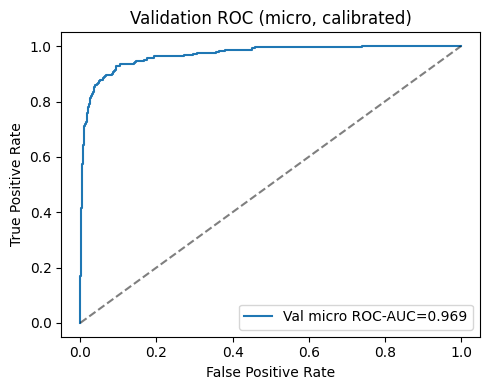

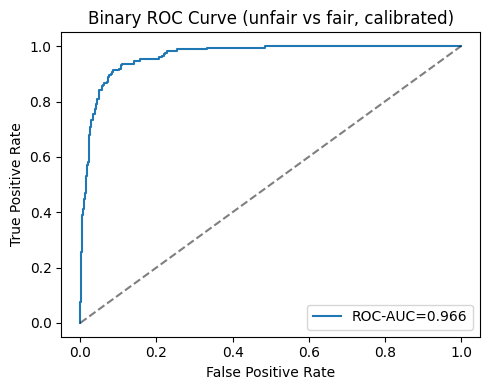

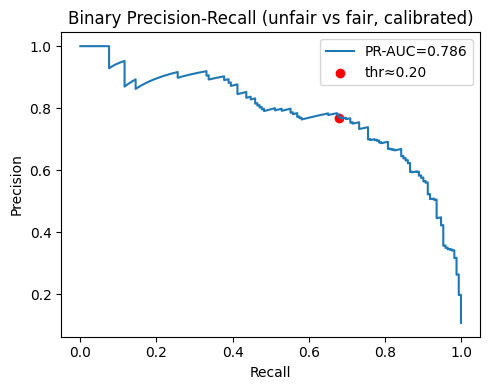

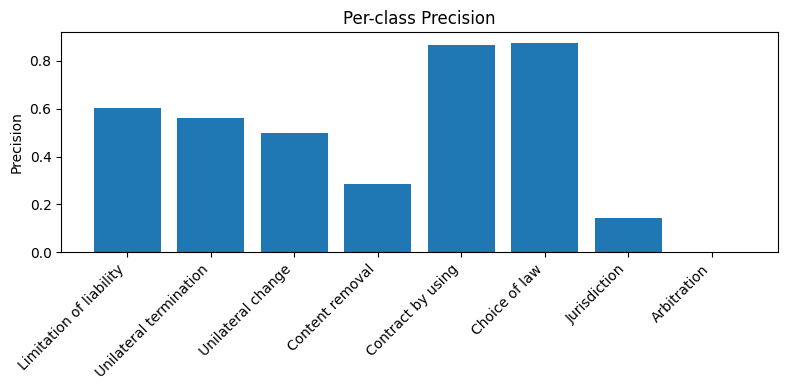

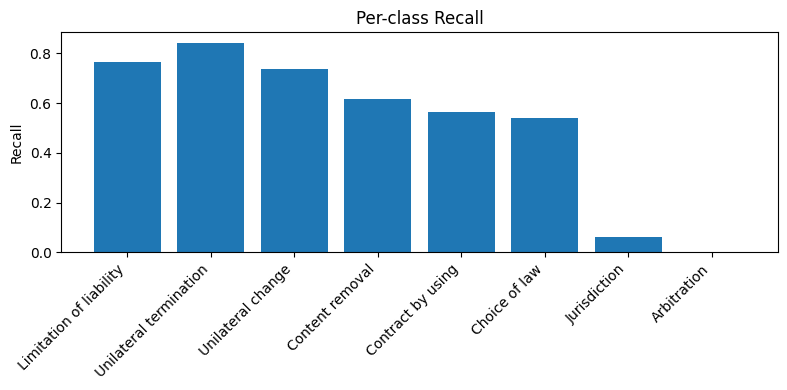

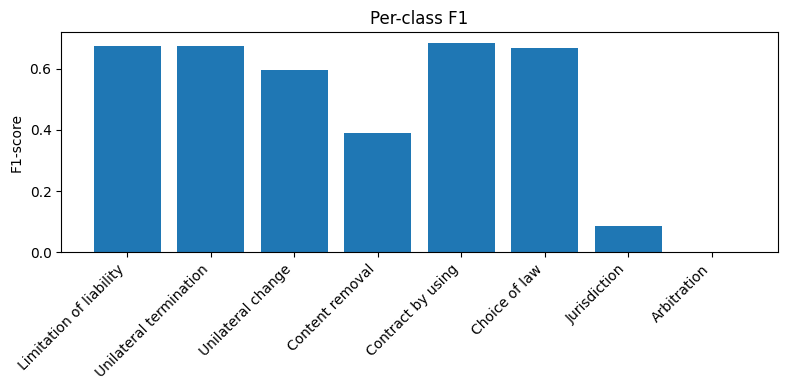

In [14]:
# ROC/PR on validation (micro, calibrated)
try:
    fpr_val, tpr_val, _ = roc_curve(val_y.ravel(), val_prob_cal.ravel())
    roc_val = roc_auc_score(val_y.ravel(), val_prob_cal.ravel())
    plt.figure(figsize=(5,4))
    plt.plot(fpr_val, tpr_val, label=f"Val micro ROC-AUC={roc_val:.3f}")
    plt.plot([0,1],[0,1],'k--', alpha=0.5)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("Validation ROC (micro, calibrated)"); plt.legend(); plt.tight_layout(); plt.show()
except ValueError:
    print("Val ROC cannot be computed (single-class present).")

# --- Binary ROC / PR (unfair vs fair) ---

# Reuse the same definition as in binary_unfair_metrics:
#   y_true_bin = 1 if any unfair type present
#   y_prob_bin = max probability over types

y_true_bin = (test_y.sum(axis=1) > 0).astype(int)
y_prob_bin = test_prob_cal.max(axis=1)

# Binary ROC curve
try:
    fpr_bin, tpr_bin, _ = roc_curve(y_true_bin, y_prob_bin)
    roc_auc_bin = roc_auc_score(y_true_bin, y_prob_bin)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr_bin, tpr_bin, label=f"ROC-AUC={roc_auc_bin:.3f}")
    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Binary ROC Curve (unfair vs fair, calibrated)")
    plt.legend()
    plt.tight_layout()
    plt.show()
except ValueError:
    print("Binary ROC cannot be computed (single-class present).")

# Binary PR curve
prec_bin, rec_bin, thr_bin = precision_recall_curve(y_true_bin, y_prob_bin)
pr_auc_bin = average_precision_score(y_true_bin, y_prob_bin)
plt.figure(figsize=(5, 4))
plt.plot(rec_bin, prec_bin, label=f"PR-AUC={pr_auc_bin:.3f}")

# Mark chosen global threshold (approximate point)
# Our test-time binary prob is y_prob_bin (max over types),
# and the decision threshold is the same global 'thr' used per-label.
if len(thr_bin) > 0:
    j = np.argmin(np.abs(thr_bin - thr))
    plt.scatter([rec_bin[j]], [prec_bin[j]],
                color="red", label=f"thr≈{thr:.2f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Binary Precision-Recall (unfair vs fair, calibrated)")
plt.legend()
plt.tight_layout()
plt.show()

precisions = per_class[0]
recalls    = per_class[1]
f1s        = per_class[2]

x = np.arange(NUM_LABELS)

plt.figure(figsize=(8,4))
plt.bar(x, precisions)
plt.xticks(x, UNFAIR_TYPES, rotation=45, ha="right")
plt.ylabel("Precision")
plt.title("Per-class Precision")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.bar(x, recalls)
plt.xticks(x, UNFAIR_TYPES, rotation=45, ha="right")
plt.ylabel("Recall")
plt.title("Per-class Recall")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.bar(x, f1s)
plt.xticks(x, UNFAIR_TYPES, rotation=45, ha="right")
plt.ylabel("F1-score")
plt.title("Per-class F1")
plt.tight_layout()
plt.show()

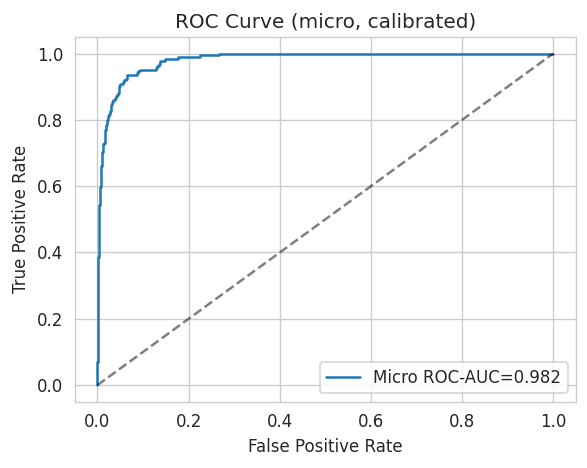

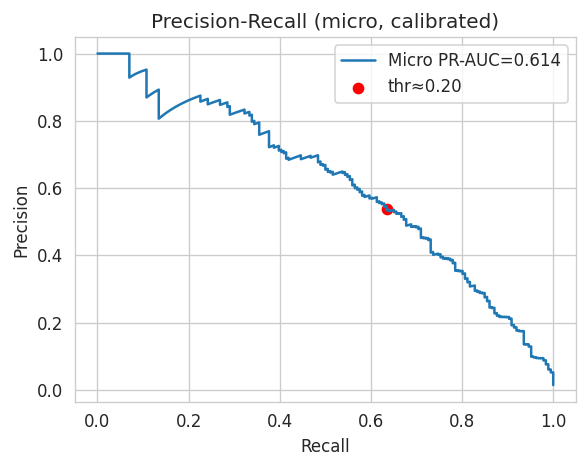

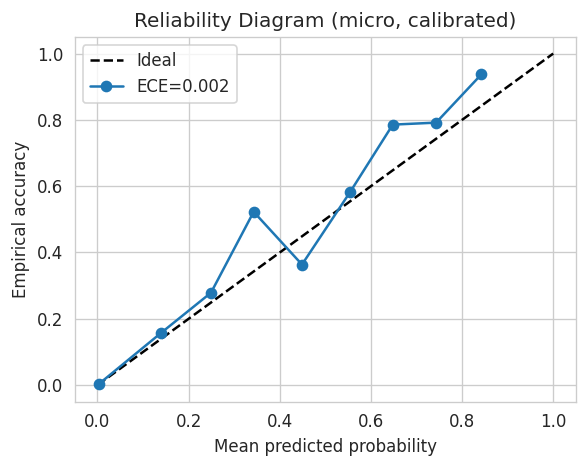

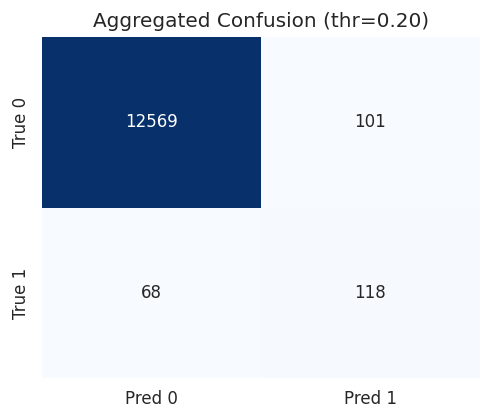

{'TP': 118, 'FP': 101, 'FN': 68, 'TN': 12569}


In [15]:
# Plots: ROC/PR (micro), reliability diagram, and aggregated confusion

sns.set_style("whitegrid"); plt.rcParams["figure.dpi"] = 120

# ROC micro
try:
    fpr, tpr, _ = roc_curve(test_y.ravel(), test_prob_cal.ravel())
    roc_micro = roc_auc_score(test_y.ravel(), test_prob_cal.ravel())
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"Micro ROC-AUC={roc_micro:.3f}")
    plt.plot([0,1],[0,1],'k--', alpha=0.5)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (micro, calibrated)"); plt.legend(); plt.tight_layout(); plt.show()
except ValueError:
    print("ROC cannot be computed (single-class present).")

# PR micro
prec, rec, pr_thr = precision_recall_curve(test_y.ravel(), test_prob_cal.ravel())
pr_auc_micro = average_precision_score(test_y.ravel(), test_prob_cal.ravel())
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"Micro PR-AUC={pr_auc_micro:.3f}")
# Mark chosen global threshold (approximate point)
if len(pr_thr)>0:
    j = np.argmin(np.abs(pr_thr - thr))
    plt.scatter([rec[j]], [prec[j]], color="red", label=f"thr≈{thr:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall (micro, calibrated)")
plt.legend(); plt.tight_layout(); plt.show()

# Reliability diagram and ECE (flattened multi-label)
def calibration_curve_uniform(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1
    prob_true, prob_pred, counts = [], [], []
    for i in range(n_bins):
        mask = binids == i
        if np.any(mask):
            prob_pred.append(y_prob[mask].mean())
            prob_true.append(y_true[mask].mean())
            counts.append(mask.mean())
    return np.array(prob_true), np.array(prob_pred), np.array(counts)

def expected_calibration_error(y_true, y_prob, n_bins=10):
    pt, pp, w = calibration_curve_uniform(y_true, y_prob, n_bins)
    return float(np.sum(w * np.abs(pt - pp)))

ece = expected_calibration_error(test_y.ravel(), test_prob_cal.ravel(), n_bins=10)

pt, pp, _ = calibration_curve_uniform(test_y.ravel(), test_prob_cal.ravel(), n_bins=10)
plt.figure(figsize=(5,4))
plt.plot([0,1],[0,1],'k--', label="Ideal")
plt.plot(pp, pt, marker='o', label=f"ECE={ece:.3f}")
plt.xlabel("Mean predicted probability"); plt.ylabel("Empirical accuracy")
plt.title("Reliability Diagram (micro, calibrated)")
plt.legend(); plt.tight_layout(); plt.show()

# Multi-label confusion (aggregated one-vs-rest)
# TP/FP/FN/TN across all labels
y_true_flat = test_y.ravel().astype(int)
y_pred_flat = y_pred_test.ravel().astype(int)
TP = int(((y_true_flat==1)&(y_pred_flat==1)).sum())
FP = int(((y_true_flat==0)&(y_pred_flat==1)).sum())
FN = int(((y_true_flat==1)&(y_pred_flat==0)).sum())
TN = int(((y_true_flat==0)&(y_pred_flat==0)).sum())

import pandas as pd
cm = np.array([[TN, FP],
               [FN, TP]])
plt.figure(figsize=(4.2,3.6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
plt.title(f"Aggregated Confusion (thr={thr:.2f})")
plt.tight_layout(); plt.show()

print({"TP":TP, "FP":FP, "FN":FN, "TN":TN})

### QUALITATIVE INSPECTION OF HIGH-SCORE PREDICTIONS AND INFERENCE HELPER FOR SINGLE-CLAUSE SUMMARIZATION ###

In [16]:
# Quick qualitative check: show a few high‑probability predictions

# Show k sentences with highest number of predicted labels and their probs
k = 5
texts_test = ds["test"]["text"]
scores = test_prob_cal
preds = (scores >= thr).astype(int)
sum_pos = preds.sum(axis=1)
order = np.argsort(-sum_pos)[:k]

for i in order:
    labs = [UNFAIR_TYPES[j] for j in np.where(preds[i]==1)[0]]
    top = sorted([(UNFAIR_TYPES[j], float(scores[i,j])) for j in range(NUM_LABELS)],
                 key=lambda x: -x[1])[:3]
    print("—"*60)
    print(texts_test[int(i)]) # Cast numpy int to standard int
    print("Predicted labels:", labs if labs else ["<none>"])
    print("Top scores:", [f"{n}={s:.2f}" for n,s in top])


# Inference helper: derive FAIR / POTENTIALLY UNFAIR note from 8-label predictions

def summarize_clause(text, model, tokenizer, scaler, threshold, device=DEVICE):
    """
    Runs the model on a single clause, returns:
      - verdict: 'FAIR' or 'POTENTIALLY UNFAIR'
      - detected unfair types (above threshold)
      - per-type probabilities
    """
    model.eval()
    norm_text = normalize_text(text)
    inputs = tokenizer([norm_text], truncation=True, padding=True, return_tensors="pt").to(device)

    with torch.no_grad():
        logits = model(**inputs).logits.cpu().numpy()[0]  # shape [NUM_LABELS], plain NumPy

    # Convert to a float32 tensor on CPU, apply temperature scaling, then back to NumPy
    logits_t = scaler.scale(torch.from_numpy(logits).float().unsqueeze(0))
    logits_t = logits_t.detach().cpu().numpy()[0]

    probs = sigmoid(logits_t)
    preds = (probs >= threshold).astype(int)

    present_types = [UNFAIR_TYPES[i] for i in range(NUM_LABELS) if preds[i] == 1]
    if len(present_types) == 0:
        verdict = "FAIR (no unfair types detected above threshold)"
    else:
        verdict = "POTENTIALLY UNFAIR (detected types: " + ", ".join(present_types) + ")"

    return {
        "text": text,
        "verdict": verdict,
        "types": present_types,
        "probs": {UNFAIR_TYPES[i]: float(probs[i]) for i in range(NUM_LABELS)}
    }

# Test on a random test clause
example_idx = int(np.random.randint(0, len(texts_test)))
example_text = texts_test[example_idx]
summary = summarize_clause(example_text, model, tokenizer, scaler, thr)

print("\n" + "="*60)
print("Example clause:")
print(example_text)
print("\nVerdict:", summary["verdict"])
print("Detected types:", summary["types"] if summary["types"] else ["<none>"])
print("Top 3 probabilities:",
      sorted(summary["probs"].items(), key=lambda x: -x[1])[:3])
print("="*60)

test_clause = (
    "We may modify these Terms at any time without prior notice, and your continued use "
    "of the service after such changes constitutes your acceptance of the new terms."
)
s = summarize_clause(test_clause, model, tokenizer, scaler, thr)
print("Verdict:", s["verdict"])
print("Detected types:", s["types"])
print(sorted(s["probs"].items(), key=lambda x: -x[1])[:3])


# Here we collapse the 8-label predictions into a single binary decision:
#  - POTENTIALLY UNFAIR if any unfair type is predicted above threshold
#  - FAIR otherwise
# This aligns with the primary binary task, while preserving type-level detail.
# ----- Derived FAIR / POTENTIALLY UNFAIR on the whole test set -----

# test_prob_cal: shape [N, 8], calibrated probs
# thr: global threshold chosen on validation
scores_test = test_prob_cal
preds_test  = (scores_test >= thr).astype(int)

# For each example: unfair if any type predicted above threshold
unfair_flag = (preds_test.max(axis=1) == 1).astype(int)   # 1 = potentially unfair, 0 = fair

# Basic counts
n = len(unfair_flag)
n_unfair = int(unfair_flag.sum())
n_fair   = int((1 - unfair_flag).sum())

print(f"Total test clauses: {n}")
print(f"Predicted FAIR: {n_fair} ({n_fair/n:.1%})")
print(f"Predicted POTENTIALLY UNFAIR: {n_unfair} ({n_unfair/n:.1%})")

————————————————————————————————————————————————————————————
we reserve the right to remove content alleged to be infringing without prior notice , at our sole discretion , and without liability to you . 

Predicted labels: ['Limitation of liability', 'Unilateral termination', 'Unilateral change', 'Content removal']
Top scores: ['Unilateral termination=0.63', 'Limitation of liability=0.35', 'Unilateral change=0.27']
————————————————————————————————————————————————————————————
we reserve the right to modify or terminate free trials at any time , without notice and in our sole discretion . 

Predicted labels: ['Unilateral termination', 'Unilateral change', 'Content removal']
Top scores: ['Unilateral termination=0.66', 'Unilateral change=0.54', 'Content removal=0.29']
————————————————————————————————————————————————————————————
if we believe you are abusing ebay in any way , we may , in our sole discretion and without limiting other remedies , limit , suspend , or terminate your user acco

### DATASET-WIDE FAIR VS POTENTIALLY UNFAIR SUMMARY ###

   idx                                               text verdict  \
0    0               last updated date : may 15 , 2017 \n    FAIR   
1    1  academia , inc. ( `` academia.edu '' or `` we ...    FAIR   
2    2  please read carefully the following terms and ...    FAIR   
3    3  these terms govern your access to and use of t...    FAIR   
4    4  arbitration notice : unless you opt out of arb...    FAIR   

  detected_types                                               top3  
0                 [(Unilateral change, 0.001981242559850216), (C...  
1                 [(Limitation of liability, 0.00145156914368271...  
2                 [(Contract by using, 0.020050087943673134), (U...  
3                 [(Contract by using, 0.008714744821190834), (J...  
4                 [(Contract by using, 0.05954063683748245), (Ju...  


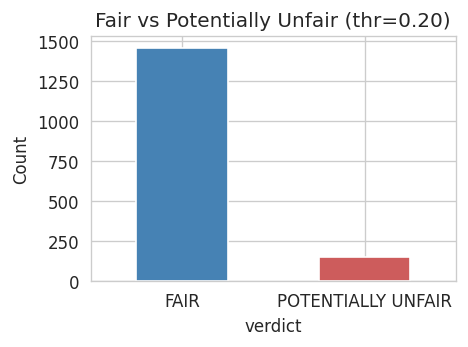

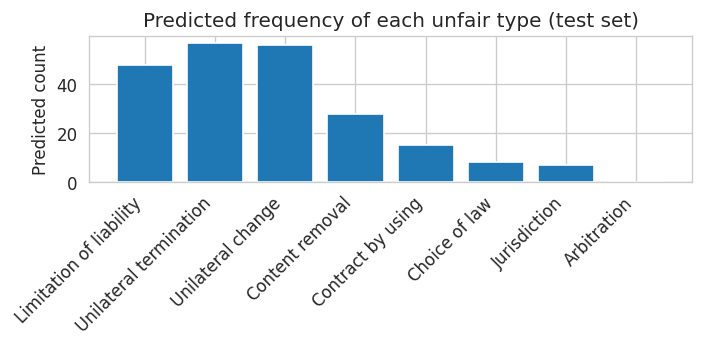

In [17]:
import pandas as pd

texts_test = ds["test"]["text"]

def top_k_types_for_row(probs_row, k=3):
    pairs = list(zip(UNFAIR_TYPES, probs_row))
    pairs_sorted = sorted(pairs, key=lambda x: -x[1])[:k]
    return [(name, float(p)) for name, p in pairs_sorted]

records = []
for i in range(len(texts_test)):
    probs_i = scores_test[i]
    preds_i = preds_test[i]
    present_types = [UNFAIR_TYPES[j] for j in np.where(preds_i == 1)[0]]
    verdict = "POTENTIALLY UNFAIR" if len(present_types) > 0 else "FAIR"
    top3 = top_k_types_for_row(probs_i, k=3)
    records.append({
        "idx": i,
        "text": texts_test[i],
        "verdict": verdict,
        "detected_types": ", ".join(present_types) if present_types else "",
        "top3": top3
    })

df_results = pd.DataFrame(records)
print(df_results.head(5))

plt.figure(figsize=(4,3))
df_results["verdict"].value_counts().plot(kind="bar", color=["steelblue", "indianred"])
plt.ylabel("Count")
plt.title(f"Fair vs Potentially Unfair (thr={thr:.2f})")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Count how often each type gets predicted (among all examples)
type_counts = preds_test.sum(axis=0)  # shape [8]

plt.figure(figsize=(6,3))
x = np.arange(NUM_LABELS)
plt.bar(x, type_counts)
plt.xticks(x, UNFAIR_TYPES, rotation=45, ha="right")
plt.ylabel("Predicted count")
plt.title("Predicted frequency of each unfair type (test set)")
plt.tight_layout()
plt.show()

### INFERENCE LATENCY MEASUREMENT AND ARTIFACT SAVING ###  

In [18]:
# Latency and model size

# Inference latency on 100 examples
sample = texts_test[:100]
inputs = tokenizer(sample, padding=True, truncation=True, return_tensors="pt").to(DEVICE)
model.eval();
with torch.no_grad(): _ = model(**inputs)  # warmup
torch.cuda.synchronize() if DEVICE.type=="cuda" else None
t0 = time.time()
with torch.no_grad():
    _ = model(**inputs)
torch.cuda.synchronize() if DEVICE.type=="cuda" else None
dt = (time.time() - t0)
print(f"Inference latency for 100 examples on {DEVICE}: {dt*1000:.1f} ms")

# Save artifacts
trainer.save_model(CFG["output_dir"])
artifacts = {
    "model_name": CFG["model_name"],
    "temperature": float(scaler.temperature.item()),
    "threshold": float(thr),
    "target_recall_micro": CFG["target_recall_micro"],
    "seed": SEED,
    "labels": UNFAIR_TYPES
}
with open(os.path.join(CFG["output_dir"], "calibration_and_threshold.json"), "w") as f:
    json.dump(artifacts, f, indent=2)
print("Saved artifacts:", artifacts)

Inference latency for 100 examples on cuda: 491.2 ms
Saved artifacts: {'model_name': 'distilbert-base-uncased', 'temperature': 0.7358956336975098, 'threshold': 0.2, 'target_recall_micro': 0.85, 'seed': 42, 'labels': ['Limitation of liability', 'Unilateral termination', 'Unilateral change', 'Content removal', 'Contract by using', 'Choice of law', 'Jurisdiction', 'Arbitration']}


### DATA EXTRACTION FOR CLASSICAL BASELINES (TF-IDF) ###

In [19]:
### TF-IDF LOGISTIC REGRESSION METHOD ###

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score

# We already have: ds, UNFAIR_TYPES, NUM_LABELS, normalize_text

def to_numpy_splits(ds):
    """Extract texts and multi-hot labels from HF DatasetDict."""
    def extract(split):
        texts = [normalize_text(t) for t in ds[split]["text"]]
        labels = np.array(ds[split]["labels"], dtype=np.float32)
        return texts, labels

    X_train, y_train = extract("train")
    X_val,   y_val   = extract("validation")
    X_test,  y_test  = extract("test")
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = to_numpy_splits(ds)
print(y_train.shape, y_val.shape, y_test.shape)  # (N, 8)

(5532, 8) (2275, 8) (1607, 8)


### BINARY TF-IDF + LOGISTIC REGRESSION BASELINE ###

In [20]:
def collapse_to_binary(y):
    # 1 if any unfair type present, otherwise 0
    return (y.sum(axis=1) > 0).astype(int)

y_train_bin = collapse_to_binary(y_train)
y_val_bin   = collapse_to_binary(y_val)
y_test_bin  = collapse_to_binary(y_test)

In [21]:
from sklearn.pipeline import make_pipeline

# Character or word n‑grams both work, word n‑grams are simpler
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    max_features=50000,
)

In [22]:
# Logistic regression for binary classification
clf_bin = LogisticRegression(
    solver="liblinear",
    max_iter=1000,
    class_weight="balanced",  # helps with imbalance
)

# Pipeline: TF‑IDF -> Logistic Regression
pipe_bin = make_pipeline(tfidf, clf_bin)
pipe_bin.fit(X_train, y_train_bin)

# Predict probabilities
val_prob_bin = pipe_bin.predict_proba(X_val)[:, 1]
test_prob_bin = pipe_bin.predict_proba(X_test)[:, 1]

# Choose a threshold on validation that emphasizes recall
def binary_metrics(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    roc = roc_auc_score(y_true, y_prob)
    pr  = average_precision_score(y_true, y_prob)
    return {"p": p, "r": r, "f1": f1, "roc_auc": roc, "pr_auc": pr}

def choose_threshold_binary(y_true, y_prob, target_recall=0.85):
    best = {"thr": 0.5, "f1": -1, "r": 0, "p": 0}
    for thr in np.linspace(0.05, 0.95, 19):
        m = binary_metrics(y_true, y_prob, thr)
        if m["r"] >= target_recall:
            if (m["f1"] > best["f1"]) or (
                np.isclose(m["f1"], best["f1"]) and m["p"] > best["p"]
            ):
                best = {"thr": float(thr), **m}
        else:
            if best["r"] < target_recall and m["f1"] > best["f1"]:
                best = {"thr": float(thr), **m}
    return best

best_val_bin = choose_threshold_binary(y_val_bin, val_prob_bin, target_recall=CFG["target_recall_micro"])
print("Binary baseline (validation) best threshold + metrics:",
      {k: round(v, 3) if isinstance(v, float) else v for k, v in best_val_bin.items()})

thr_bin = best_val_bin["thr"]
metrics_test_bin = binary_metrics(y_test_bin, test_prob_bin, thr=thr_bin)
print("\nBinary baseline (test) metrics @ thr={:.2f}:".format(thr_bin),
      {k: round(v, 3) for k, v in metrics_test_bin.items()})

Binary baseline (validation) best threshold + metrics: {'thr': 0.45, 'p': 0.533, 'r': 0.87, 'f1': 0.661, 'roc_auc': 0.958, 'pr_auc': 0.803}

Binary baseline (test) metrics @ thr=0.45: {'p': 0.572, 'r': 0.895, 'f1': 0.698, 'roc_auc': 0.972, 'pr_auc': 0.861}


### MULTI-LABEL TF-IDF + ONE-VS-REST LOGISTIC REGRESSION ###

In [23]:
# Multi‑label classifier: OneVsRest over logistic regressions
clf_multi = OneVsRestClassifier(
    LogisticRegression(
        solver="liblinear",
        max_iter=1000,
        class_weight="balanced",
    )
)

pipe_multi = make_pipeline(tfidf, clf_multi)
pipe_multi.fit(X_train, y_train)   # y_train is (N, 8) multi‑hot

# Predict type‑level probabilities
val_prob_multi  = pipe_multi.predict_proba(X_val)   # shape (N_val, 8)
test_prob_multi = pipe_multi.predict_proba(X_test)  # shape (N_test, 8)

# Reuse existing multilabel_metrics and binary_unfair_metrics
val_metrics_multi  = multilabel_metrics(y_val,  val_prob_multi,  thr=0.5)
test_metrics_multi = multilabel_metrics(y_test, test_prob_multi, thr=0.5)
print("\nMulti‑label TF‑IDF+LR (validation) @ thr=0.50:",
      {k: round(v, 3) for k, v in val_metrics_multi.items()})
print("Multi‑label TF‑IDF+LR (test) @ thr=0.50:",
      {k: round(v, 3) for k, v in test_metrics_multi.items()})

# Also compute unfair/fair binary metrics by collapsing types
test_metrics_multi_bin = binary_unfair_metrics(y_test, test_prob_multi, thr=0.5)
print("Multi‑label TF‑IDF+LR (binary unfair vs fair, test) @ thr=0.50:",
      {k: round(v, 3) for k, v in test_metrics_multi_bin.items()})


Multi‑label TF‑IDF+LR (validation) @ thr=0.50: {'p_micro': 0.484, 'r_micro': 0.827, 'f1_micro': 0.61, 'p_macro': 0.529, 'r_macro': 0.811, 'f1_macro': 0.622, 'roc_auc_macro': 0.988, 'roc_auc_micro': 0.987, 'pr_auc_macro': 0.728, 'pr_auc_micro': 0.722}
Multi‑label TF‑IDF+LR (test) @ thr=0.50: {'p_micro': 0.567, 'r_micro': 0.844, 'f1_micro': 0.678, 'p_macro': 0.6, 'r_macro': 0.865, 'f1_macro': 0.692, 'roc_auc_macro': 0.993, 'roc_auc_micro': 0.992, 'pr_auc_macro': 0.823, 'pr_auc_micro': 0.76}
Multi‑label TF‑IDF+LR (binary unfair vs fair, test) @ thr=0.50: {'p_bin': 0.699, 'r_bin': 0.878, 'f1_bin': 0.778, 'roc_auc_bin': 0.975, 'pr_auc_bin': 0.861}


### BASELINE THRESHOLD TUNING AND METRIC REPORTING ###

In [24]:
best_val_multi = choose_global_threshold(y_val, val_prob_multi, CFG["target_recall_micro"])
print("\nMulti‑label TF‑IDF+LR (validation) best threshold + metrics:",
      {k: round(v, 3) if isinstance(v, float) else v for k, v in best_val_multi.items()})

thr_multi = best_val_multi["thr"]
test_metrics_multi_thr = multilabel_metrics(y_test, test_prob_multi, thr=thr_multi)
test_metrics_multi_thr_bin = binary_unfair_metrics(y_test, test_prob_multi, thr=thr_multi)
print("Multi‑label TF‑IDF+LR (test) @ thr={:.2f}:".format(thr_multi),
      {k: round(v, 3) for k, v in test_metrics_multi_thr.items()})
print("Multi‑label TF‑IDF+LR (binary unfair vs fair, test) @ thr={:.2f}:".format(thr_multi),
      {k: round(v, 3) for k, v in test_metrics_multi_thr_bin.items()})


Multi‑label TF‑IDF+LR (validation) best threshold + metrics: {'thr': 0.4, 'p_micro': 0.411, 'r_micro': 0.867, 'f1_micro': 0.557, 'p_macro': 0.475, 'r_macro': 0.859, 'f1_macro': 0.587, 'roc_auc_macro': 0.988, 'roc_auc_micro': 0.987, 'pr_auc_macro': 0.728, 'pr_auc_micro': 0.722}
Multi‑label TF‑IDF+LR (test) @ thr=0.40: {'p_micro': 0.43, 'r_micro': 0.871, 'f1_micro': 0.575, 'p_macro': 0.489, 'r_macro': 0.888, 'f1_macro': 0.609, 'roc_auc_macro': 0.993, 'roc_auc_micro': 0.992, 'pr_auc_macro': 0.823, 'pr_auc_micro': 0.76}
Multi‑label TF‑IDF+LR (binary unfair vs fair, test) @ thr=0.40: {'p_bin': 0.549, 'r_bin': 0.907, 'f1_bin': 0.684, 'roc_auc_bin': 0.975, 'pr_auc_bin': 0.861}


### DISTILBERT VS TF-IDF PERFORMANCE COMPARISON ###

In [25]:
### COMPARISON OF BOTH APPROACHES ###

### Compute metrics for both models

y_true = np.asarray(test_y, dtype=np.float32)           # ground truth (N, 8)
prob_distil = np.asarray(test_prob_cal, dtype=np.float32)
prob_tfidf  = np.asarray(test_prob_multi, dtype=np.float32)

best_val_tfidf = choose_global_threshold(val_y, val_prob_multi, CFG["target_recall_micro"])
thr_tfidf = best_val_tfidf["thr"]
print("TF-IDF best val threshold:", best_val_tfidf)

# Multi-label metrics at each model's own threshold
metrics_distil_multi = multilabel_metrics(y_true, prob_distil, thr=thr)
metrics_tfidf_multi  = multilabel_metrics(y_true, prob_tfidf,  thr=thr_tfidf)

# Binary unfair vs fair metrics (collapse labels)
metrics_distil_bin = binary_unfair_metrics(y_true, prob_distil, thr=thr)
metrics_tfidf_bin  = binary_unfair_metrics(y_true, prob_tfidf,  thr=thr_tfidf)

print("DistilBERT (multi):",
      {k: round(v,3) for k,v in metrics_distil_multi.items()})
print("TF-IDF+LR (multi):",
      {k: round(v,3) for k,v in metrics_tfidf_multi.items()})

print("DistilBERT (binary):",
      {k: round(v,3) for k,v in metrics_distil_bin.items()})
print("TF-IDF+LR (binary):",
      {k: round(v,3) for k,v in metrics_tfidf_bin.items()})

TF-IDF best val threshold: {'thr': 0.39999999999999997, 'p_micro': 0.41064638783269963, 'r_micro': 0.8674698795180723, 'f1_micro': 0.5574193548387096, 'p_macro': 0.475011949932836, 'r_macro': 0.8586629503812656, 'f1_macro': 0.5870424339829954, 'roc_auc_macro': 0.9875213206395844, 'roc_auc_micro': 0.9868076841934056, 'pr_auc_macro': 0.7282633252182208, 'pr_auc_micro': 0.7221866985726104}
DistilBERT (multi): {'p_micro': 0.539, 'r_micro': 0.634, 'f1_micro': 0.583, 'p_macro': 0.479, 'r_macro': 0.515, 'f1_macro': 0.471, 'roc_auc_macro': 0.982, 'roc_auc_micro': 0.982, 'pr_auc_macro': 0.562, 'pr_auc_micro': 0.614}
TF-IDF+LR (multi): {'p_micro': 0.43, 'r_micro': 0.871, 'f1_micro': 0.575, 'p_macro': 0.489, 'r_macro': 0.888, 'f1_macro': 0.609, 'roc_auc_macro': 0.993, 'roc_auc_micro': 0.992, 'pr_auc_macro': 0.823, 'pr_auc_micro': 0.76}
DistilBERT (binary): {'p_bin': 0.775, 'r_bin': 0.68, 'f1_bin': 0.724, 'roc_auc_bin': 0.966, 'pr_auc_bin': 0.786}
TF-IDF+LR (binary): {'p_bin': 0.549, 'r_bin': 0.90

### MICRO-LEVEL ROC AND PR CURVE COMPARISON ###

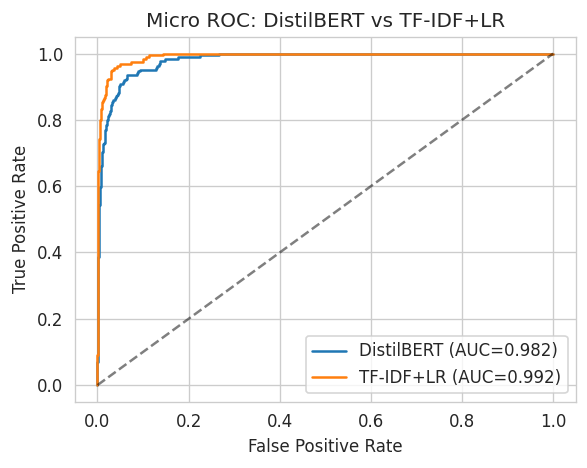

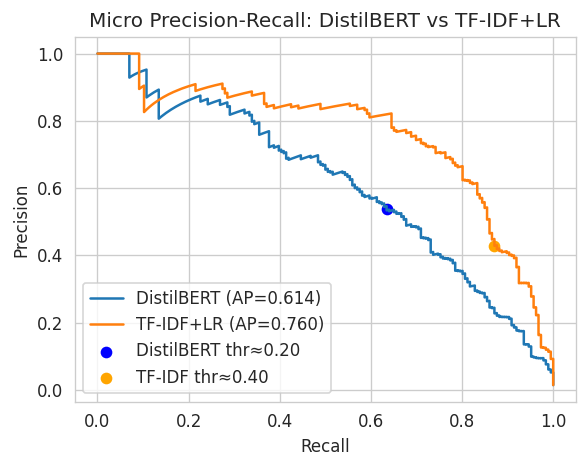

In [26]:
### Micro ROC and PR curves (both models on the same plot)

from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# Flatten to micro level
y_flat = y_true.ravel()

# DistilBERT
fpr_d, tpr_d, _ = roc_curve(y_flat, prob_distil.ravel())
roc_micro_d = roc_auc_score(y_flat, prob_distil.ravel())

prec_d, rec_d, thr_d = precision_recall_curve(y_flat, prob_distil.ravel())
pr_micro_d = average_precision_score(y_flat, prob_distil.ravel())

# TF-IDF
fpr_t, tpr_t, _ = roc_curve(y_flat, prob_tfidf.ravel())
roc_micro_t = roc_auc_score(y_flat, prob_tfidf.ravel())

prec_t, rec_t, thr_t = precision_recall_curve(y_flat, prob_tfidf.ravel())
pr_micro_t = average_precision_score(y_flat, prob_tfidf.ravel())

# ROC comparison
plt.figure(figsize=(5,4))
plt.plot(fpr_d, tpr_d, label=f"DistilBERT (AUC={roc_micro_d:.3f})")
plt.plot(fpr_t, tpr_t, label=f"TF-IDF+LR (AUC={roc_micro_t:.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Micro ROC: DistilBERT vs TF-IDF+LR")
plt.legend(); plt.tight_layout(); plt.show()

# PR comparison
plt.figure(figsize=(5,4))
plt.plot(rec_d, prec_d, label=f"DistilBERT (AP={pr_micro_d:.3f})")
plt.plot(rec_t, prec_t, label=f"TF-IDF+LR (AP={pr_micro_t:.3f})")

# Mark operating thresholds (approximate) for each model
if len(thr_d) > 0:
    j_d = np.argmin(np.abs(thr_d - thr))
    plt.scatter([rec_d[j_d]], [prec_d[j_d]], color="blue", marker="o",
                label=f"DistilBERT thr≈{thr:.2f}")
if len(thr_t) > 0:
    j_t = np.argmin(np.abs(thr_t - thr_tfidf))
    plt.scatter([rec_t[j_t]], [prec_t[j_t]], color="orange", marker="o",
                label=f"TF-IDF thr≈{thr_tfidf:.2f}")

plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Micro Precision-Recall: DistilBERT vs TF-IDF+LR")
plt.legend(); plt.tight_layout(); plt.show()

### BINARY UNFAIR VS FAIR ROC/PR COMPARISON ###

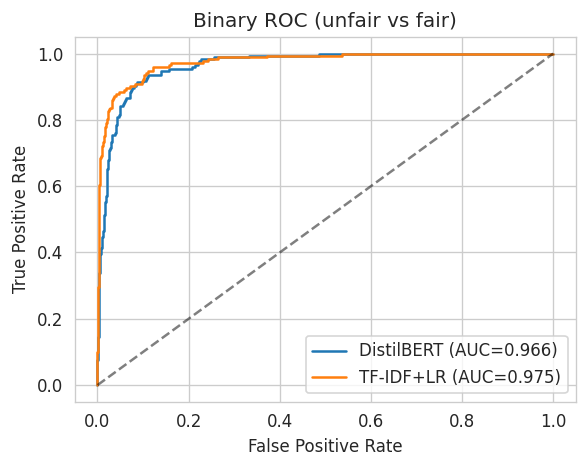

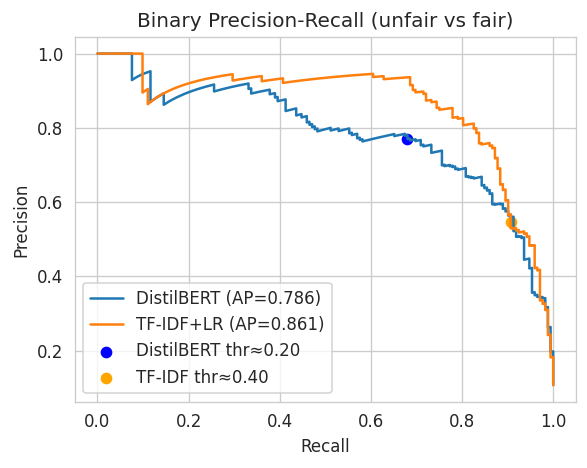

In [27]:
### Binary unfair vs fair ROC and PR comparison

# Binary ground truth/probabilities for both models
y_true_bin = (y_true.sum(axis=1) > 0).astype(int)
y_prob_bin_distil = prob_distil.max(axis=1)
y_prob_bin_tfidf  = prob_tfidf.max(axis=1)

# ROC
fpr_bd, tpr_bd, _ = roc_curve(y_true_bin, y_prob_bin_distil)
roc_bd = roc_auc_score(y_true_bin, y_prob_bin_distil)

fpr_bt, tpr_bt, _ = roc_curve(y_true_bin, y_prob_bin_tfidf)
roc_bt = roc_auc_score(y_true_bin, y_prob_bin_tfidf)

plt.figure(figsize=(5,4))
plt.plot(fpr_bd, tpr_bd, label=f"DistilBERT (AUC={roc_bd:.3f})")
plt.plot(fpr_bt, tpr_bt, label=f"TF-IDF+LR (AUC={roc_bt:.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Binary ROC (unfair vs fair)")
plt.legend(); plt.tight_layout(); plt.show()

# PR
prec_bd, rec_bd, thr_bd = precision_recall_curve(y_true_bin, y_prob_bin_distil)
pr_bd = average_precision_score(y_true_bin, y_prob_bin_distil)

prec_bt, rec_bt, thr_bt = precision_recall_curve(y_true_bin, y_prob_bin_tfidf)
pr_bt = average_precision_score(y_true_bin, y_prob_bin_tfidf)

plt.figure(figsize=(5,4))
plt.plot(rec_bd, prec_bd, label=f"DistilBERT (AP={pr_bd:.3f})")
plt.plot(rec_bt, prec_bt, label=f"TF-IDF+LR (AP={pr_bt:.3f})")

# Mark operating points
if len(thr_bd) > 0:
    j_bd = np.argmin(np.abs(thr_bd - thr))
    plt.scatter([rec_bd[j_bd]], [prec_bd[j_bd]],
                color="blue", marker="o", label=f"DistilBERT thr≈{thr:.2f}")
if len(thr_bt) > 0:
    j_bt = np.argmin(np.abs(thr_bt - thr_tfidf))
    plt.scatter([rec_bt[j_bt]], [prec_bt[j_bt]],
                color="orange", marker="o", label=f"TF-IDF thr≈{thr_tfidf:.2f}")

plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Binary Precision-Recall (unfair vs fair)")
plt.legend(); plt.tight_layout(); plt.show()

### BAR PLOTS OF MICRO AND MACRO P/R/F1 FOR BOTH MODELS ###

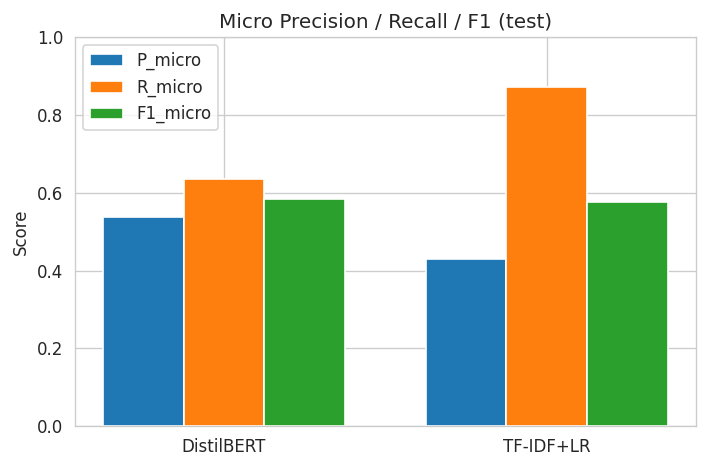

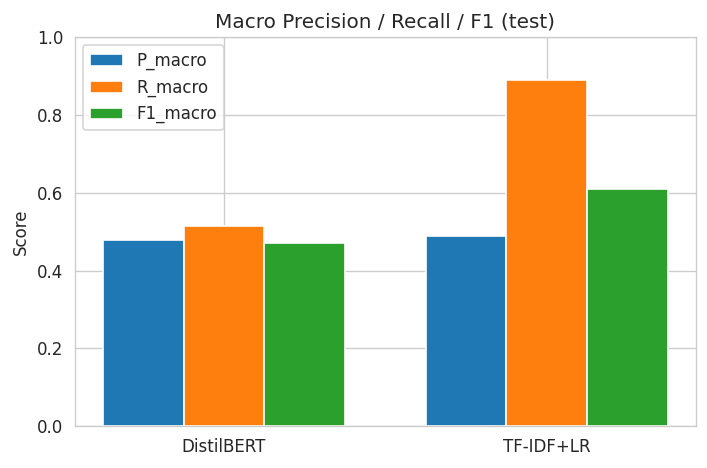

In [28]:
#### Bar plots for precision / recall / F1 (per model)

# Collect a few key metrics into a DataFrame for plotting
import pandas as pd

rows = []
rows.append({
    "model": "DistilBERT",
    "type": "multi",
    "p_micro": metrics_distil_multi["p_micro"],
    "r_micro": metrics_distil_multi["r_micro"],
    "f1_micro": metrics_distil_multi["f1_micro"],
    "p_macro": metrics_distil_multi["p_macro"],
    "r_macro": metrics_distil_multi["r_macro"],
    "f1_macro": metrics_distil_multi["f1_macro"],
})
rows.append({
    "model": "TF-IDF+LR",
    "type": "multi",
    "p_micro": metrics_tfidf_multi["p_micro"],
    "r_micro": metrics_tfidf_multi["r_micro"],
    "f1_micro": metrics_tfidf_multi["f1_micro"],
    "p_macro": metrics_tfidf_multi["p_macro"],
    "r_macro": metrics_tfidf_multi["r_macro"],
    "f1_macro": metrics_tfidf_multi["f1_macro"],
})

df_metrics = pd.DataFrame(rows)

plt.figure(figsize=(6,4))
x = np.arange(2)  # two models
w = 0.25
plt.bar(x - w, df_metrics["p_micro"], width=w, label="P_micro")
plt.bar(x      , df_metrics["r_micro"], width=w, label="R_micro")
plt.bar(x + w, df_metrics["f1_micro"], width=w, label="F1_micro")
plt.xticks(x, df_metrics["model"])
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.title("Micro Precision / Recall / F1 (test)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.bar(x - w, df_metrics["p_macro"], width=w, label="P_macro")
plt.bar(x      , df_metrics["r_macro"], width=w, label="R_macro")
plt.bar(x + w, df_metrics["f1_macro"], width=w, label="F1_macro")
plt.xticks(x, df_metrics["model"])
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.title("Macro Precision / Recall / F1 (test)")
plt.legend()
plt.tight_layout()
plt.show()

### CALIBRATION COMPARISON BETWEEN MODELS ###

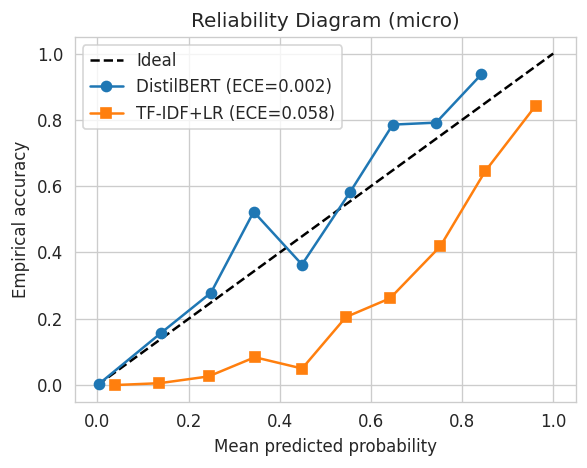

In [29]:
### Calibration comparison

# DistilBERT calibration
ece_distil = expected_calibration_error(y_true.ravel(), prob_distil.ravel(), n_bins=10)
pt_d, pp_d, _ = calibration_curve_uniform(y_true.ravel(), prob_distil.ravel(), n_bins=10)

# TF-IDF calibration
ece_tfidf = expected_calibration_error(y_true.ravel(), prob_tfidf.ravel(), n_bins=10)
pt_t, pp_t, _ = calibration_curve_uniform(y_true.ravel(), prob_tfidf.ravel(), n_bins=10)

plt.figure(figsize=(5,4))
plt.plot([0,1],[0,1],'k--', label="Ideal")
plt.plot(pp_d, pt_d, marker='o', label=f"DistilBERT (ECE={ece_distil:.3f})")
plt.plot(pp_t, pt_t, marker='s', label=f"TF-IDF+LR (ECE={ece_tfidf:.3f})")
plt.xlabel("Mean predicted probability"); plt.ylabel("Empirical accuracy")
plt.title("Reliability Diagram (micro)")
plt.legend(); plt.tight_layout(); plt.show()

### SUMMARY TABLE OF KEY METRICS ###

In [30]:
## SUMMARY TABLES

import pandas as pd

rows = []

# DistilBERT final
rows.append({
    "model": "DistilBERT",
    "variant": "norm+calib",
    "thr": thr,
    "p_micro": metrics_test["p_micro"],
    "r_micro": metrics_test["r_micro"],
    "f1_micro": metrics_test["f1_micro"],
    "p_macro": metrics_test["p_macro"],
    "r_macro": metrics_test["r_macro"],
    "f1_macro": metrics_test["f1_macro"],
    "roc_auc_micro": metrics_test["roc_auc_micro"],
    "pr_auc_micro": metrics_test["pr_auc_micro"],
})

# TF‑IDF baseline
rows.append({
    "model": "TF‑IDF+LR",
    "variant": "baseline",
    "thr": thr_tfidf,
    "p_micro": metrics_tfidf_multi["p_micro"],
    "r_micro": metrics_tfidf_multi["r_micro"],
    "f1_micro": metrics_tfidf_multi["f1_micro"],
    "p_macro": metrics_tfidf_multi["p_macro"],
    "r_macro": metrics_tfidf_multi["r_macro"],
    "f1_macro": metrics_tfidf_multi["f1_macro"],
    "roc_auc_micro": metrics_tfidf_multi["roc_auc_micro"],
    "pr_auc_micro": metrics_tfidf_multi["pr_auc_micro"],
})

df_summary = pd.DataFrame(rows)
display(df_summary.round(3))

,model,variant,thr,p_micro,r_micro,f1_micro,p_macro,r_macro,f1_macro,roc_auc_micro,pr_auc_micro
0,DistilBERT,norm+calib,0.2,0.539,0.634,0.583,0.479,0.515,0.471,0.982,0.614
1,TF‑IDF+LR,baseline,0.4,0.430,0.871,0.575,0.489,0.888,0.609,0.992,0.760


### BINARY CONFUSION MATRIX FOR DISTILBERT PREDICTIONS ###

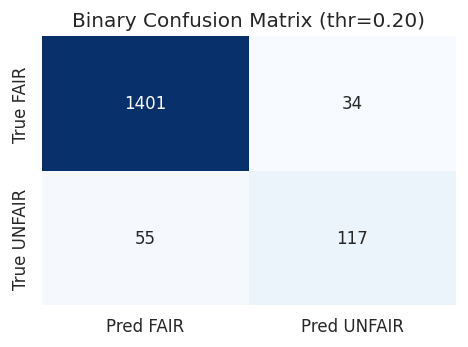

In [31]:
## Confusion matrix for the binary unfair vs fair task

from sklearn.metrics import confusion_matrix

# Binary ground truth and preds (DistilBERT)
y_true_bin = (test_y.sum(axis=1) > 0).astype(int)
y_prob_bin = test_prob_cal.max(axis=1)
y_pred_bin = (y_prob_bin >= thr).astype(int)

cm_bin = confusion_matrix(y_true_bin, y_pred_bin)
plt.figure(figsize=(4,3))
sns.heatmap(cm_bin, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred FAIR","Pred UNFAIR"],
            yticklabels=["True FAIR","True UNFAIR"])
plt.title(f"Binary Confusion Matrix (thr={thr:.2f})")
plt.tight_layout()
plt.show()

### PER-CLASS SUPPORT ANALYSIS ###

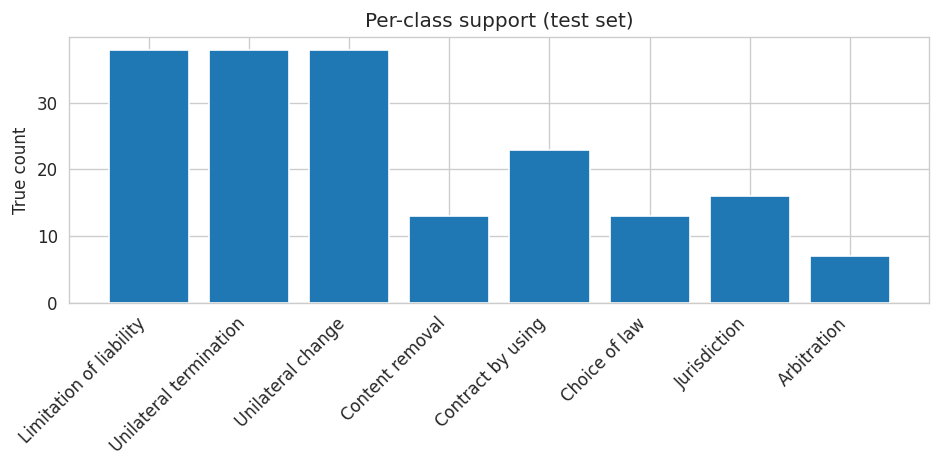

In [32]:
### Per‑class support (how many true examples per label)

_, _, _, support = precision_recall_fscore_support(
    test_y, y_pred_test, average=None, zero_division=0
)

plt.figure(figsize=(8,4))
x = np.arange(NUM_LABELS)
plt.bar(x, support)
plt.xticks(x, UNFAIR_TYPES, rotation=45, ha="right")
plt.ylabel("True count")
plt.title("Per-class support (test set)")
plt.tight_layout()
plt.show()

### THRESHOLD–METRIC TRADE-OFF CURVES (DISTILBERT) ###

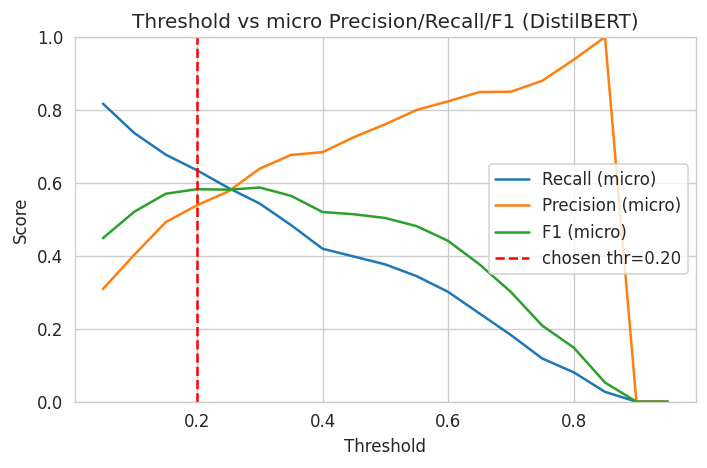

In [33]:
## Threshold–metric curves (to show the recall–precision trade‑off)

thrs = np.linspace(0.05, 0.95, 19)
r_list, p_list, f1_list = [], [], []

for t in thrs:
    m = multilabel_metrics(test_y, test_prob_cal, thr=t)
    r_list.append(m["r_micro"])
    p_list.append(m["p_micro"])
    f1_list.append(m["f1_micro"])

plt.figure(figsize=(6,4))
plt.plot(thrs, r_list, label="Recall (micro)")
plt.plot(thrs, p_list, label="Precision (micro)")
plt.plot(thrs, f1_list, label="F1 (micro)")
plt.axvline(thr, color="red", linestyle="--", label=f"chosen thr={thr:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.ylim(0,1)
plt.title("Threshold vs micro Precision/Recall/F1 (DistilBERT)")
plt.legend()
plt.tight_layout()
plt.show()

### THRESHOLD–METRIC TRADE-OFF CURVES (TF-IDF + LR) ###

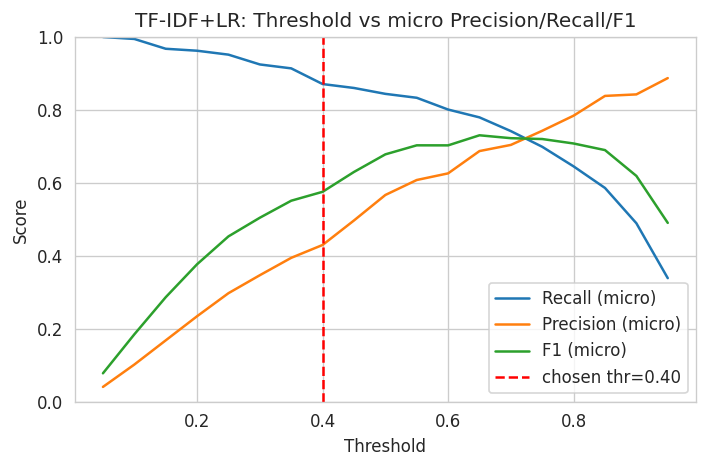

In [36]:
y_true_tfidf = np.asarray(test_y, dtype=np.float32)
prob_tfidf   = np.asarray(test_prob_multi, dtype=np.float32)

thrs = np.linspace(0.05, 0.95, 19)
r_list, p_list, f1_list = [], [], []

for t in thrs:
    m = multilabel_metrics(y_true_tfidf, prob_tfidf, thr=t)
    r_list.append(m["r_micro"])
    p_list.append(m["p_micro"])
    f1_list.append(m["f1_micro"])

plt.figure(figsize=(6,4))
plt.plot(thrs, r_list, label="Recall (micro)")
plt.plot(thrs, p_list, label="Precision (micro)")
plt.plot(thrs, f1_list, label="F1 (micro)")
plt.axvline(thr_tfidf, color="red", linestyle="--",
            label=f"chosen thr={thr_tfidf:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.title("TF-IDF+LR: Threshold vs micro Precision/Recall/F1")
plt.legend()
plt.tight_layout()
plt.show()

### PREDICTED PROBABILITY HISTOGRAMS (BOTH MODELS) ###

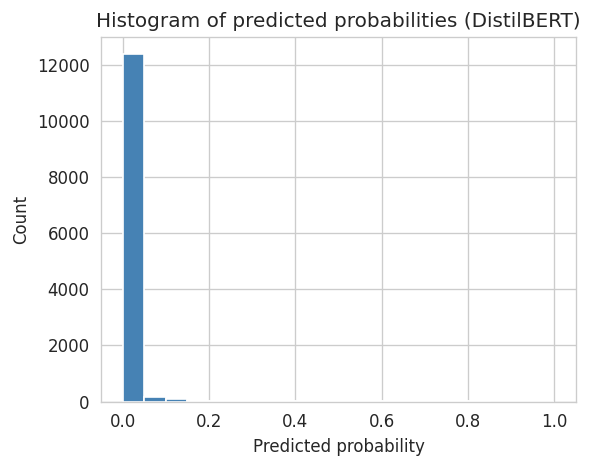

In [34]:
### Calibration histogram

plt.figure(figsize=(5,4))
plt.hist(test_prob_cal.ravel(), bins=20, range=(0,1), color="steelblue")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Histogram of predicted probabilities (DistilBERT)")
plt.tight_layout()
plt.show()

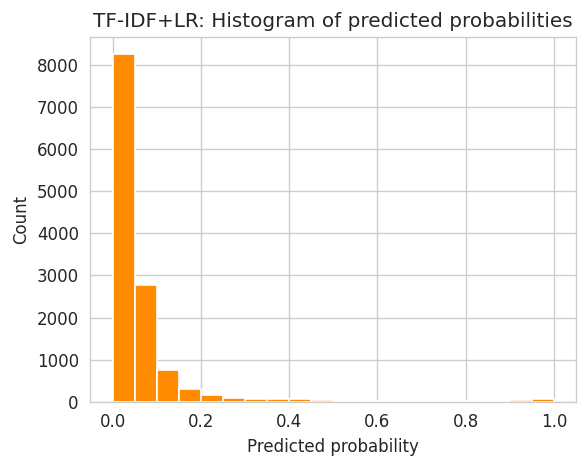

In [37]:
# Flatten all probabilities for a simple histogram
plt.figure(figsize=(5,4))
plt.hist(prob_tfidf.ravel(), bins=20, range=(0,1), color="darkorange")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("TF-IDF+LR: Histogram of predicted probabilities")
plt.tight_layout()
plt.show()

### TOP-K TYPE ACCURACY ON UNFAIR CLAUSES ###

In [38]:
# Top-k type accuracy for unfair clauses only (k=1 and k=3)
K_LIST = [1, 3]

y_true = np.asarray(test_y, dtype=np.float32)
prob_distil = np.asarray(test_prob_cal, dtype=np.float32)
prob_tfidf  = np.asarray(test_prob_multi, dtype=np.float32)

# Consider only clauses that are truly unfair (at least one label = 1)
unfair_mask = y_true.sum(axis=1) > 0
y_true_unfair = y_true[unfair_mask]
prob_distil_unfair = prob_distil[unfair_mask]
prob_tfidf_unfair  = prob_tfidf[unfair_mask]

def topk_type_accuracy(y_true_unfair, prob_unfair, k):
    """
    For each unfair clause, check if any of the true labels appear
    in the top-k predicted labels by probability.
    """
    # Indices of true labels for each example
    true_indices = [np.where(row == 1)[0] for row in y_true_unfair]

    # Indices of top-k predicted labels for each example
    topk_pred = np.argsort(-prob_unfair, axis=1)[:, :k]  # shape (N_unfair, k)

    hits = 0
    total = len(true_indices)
    for i, true_idx in enumerate(true_indices):
        if len(true_idx) == 0:
            continue
        if np.intersect1d(true_idx, topk_pred[i]).size > 0:
            hits += 1
    return hits / total if total > 0 else float("nan")

print(f"# unfair clauses in test set: {len(y_true_unfair)}")

for k in K_LIST:
    acc_distil = topk_type_accuracy(y_true_unfair, prob_distil_unfair, k)
    acc_tfidf  = topk_type_accuracy(y_true_unfair, prob_tfidf_unfair,  k)
    print(f"\nTop-{k} type accuracy on UNFAIR clauses only:")
    print(f"  DistilBERT:  {acc_distil:.3f}")
    print(f"  TF-IDF+LR:   {acc_tfidf:.3f}")

# unfair clauses in test set: 172

Top-1 type accuracy on UNFAIR clauses only:
  DistilBERT:  0.831
  TF-IDF+LR:   0.907

Top-3 type accuracy on UNFAIR clauses only:
  DistilBERT:  0.959
  TF-IDF+LR:   1.000


### FINAL TF-IDF CALIBRATION AND RELIABILITY DIAGRAM ###

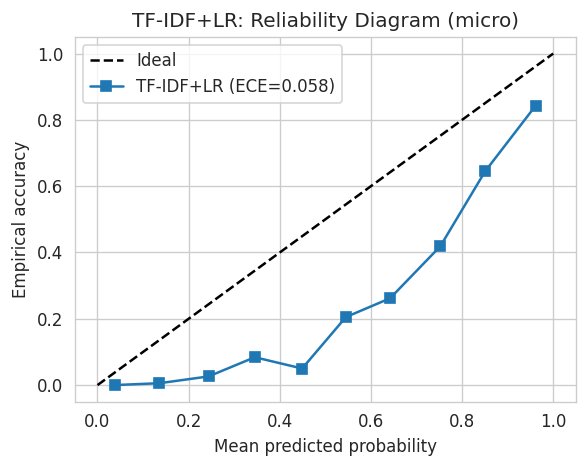

In [39]:
# Uses the same helpers as DistilBERT
# expected_calibration_error, calibration_curve_uniform

ece_tfidf = expected_calibration_error(y_true_tfidf.ravel(), prob_tfidf.ravel(), n_bins=10)
pt_t, pp_t, _ = calibration_curve_uniform(y_true_tfidf.ravel(), prob_tfidf.ravel(), n_bins=10)

plt.figure(figsize=(5,4))
plt.plot([0,1], [0,1], 'k--', label="Ideal")
plt.plot(pp_t, pt_t, marker='s', label=f"TF-IDF+LR (ECE={ece_tfidf:.3f})")
plt.xlabel("Mean predicted probability")
plt.ylabel("Empirical accuracy")
plt.title("TF-IDF+LR: Reliability Diagram (micro)")
plt.legend()
plt.tight_layout()
plt.show()